In [16]:

import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap

# -------- data --------
key = random.PRNGKey(0)
n = 1000

key, k1, k2 = random.split(key, 3)
q1 = random.uniform(k1, (n,), minval=-1.0, maxval=1.0)
q2 = random.uniform(k2, (n,), minval=-1.0, maxval=1.0)

def f_targets(q1, q2):
    X1 = q1 + q2 - 1.0
    X2 = q1 - q2**2 + 1.0
    return jnp.stack([X1, X2], axis=-1)

X = jnp.stack([q1, q2], axis=-1)         # shape (n, 2)
Y = f_targets(q1, q2)                    # shape (n, 2)

# -------- model (2-2-2-2) --------
def init_params(key):
    # He/Glorot wäre auch ok – hier simple Uniform wie bei dir
    keys = random.split(key, 6)
    def W(k): return random.uniform(k, (2, 2), minval=-1.0, maxval=1.0)
    def b():  return jnp.zeros((2,))
    params = {
        "W1": W(keys[0]), "b1": b(),
        "W2": W(keys[1]), "b2": b(),
        "W3": W(keys[2]), "b3": b(),
    }
    return params

def activation(z, layer_idx):
    # Hidden layers
    if layer_idx in (0, 1):
        return jnp.tanh(z)
    # Output layer linear lassen
    return z


def forward_single(params, x):
    # x shape (2,)
    z1 = x @ params["W1"].T + params["b1"]
    a1 = activation(z1, 0)

    z2 = a1 @ params["W2"].T + params["b2"]
    a2 = activation(z2, 1)

    z3 = a2 @ params["W3"].T + params["b3"]
    out = activation(z3, 2)
    return out

forward_batch = vmap(forward_single, in_axes=(None, 0))  # (params, X[n,2]) -> (n,2)

def mse_loss(params, X, Y):
    pred = forward_batch(params, X)
    return jnp.mean(jnp.sum((pred - Y) ** 2, axis=-1))

# -------- training --------
@jit
def train_step(params, X, Y, lr):
    grads = grad(mse_loss)(params, X, Y)
    params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, grads)
    loss = mse_loss(params, X, Y)
    return params, loss

params = init_params(key)
lr = 0.01
epochs = 200000

loss_history = []
for epoch in range(epochs):
    params, loss = train_step(params, X, Y, lr)
    loss_history.append(loss)

print("Final loss:", float(loss_history[-1]))

# -------- test --------
test = jnp.array([0.5, 0.3])
pred = forward_single(params, test)
exp = f_targets(test[0], test[1])

print("Input:", test)
print("Pred :", pred)
print("Exp  :", exp)


Final loss: 0.003814003663137555
Input: [0.5 0.3]
Pred : [-0.20955426  1.4216361 ]
Exp  : [-0.19999999  1.41      ]


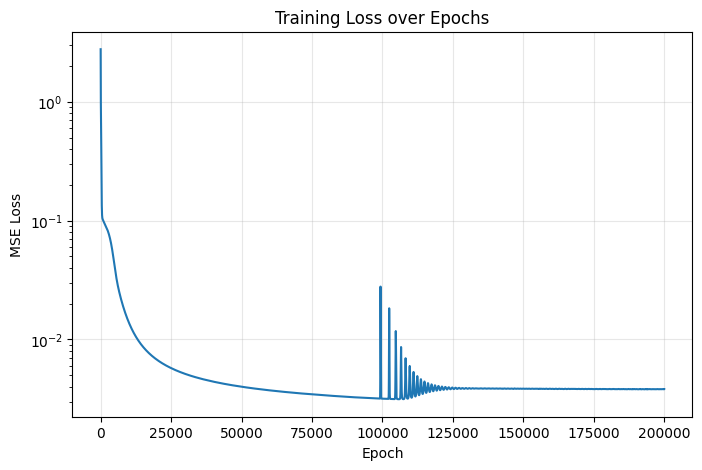

In [17]:
import matplotlib.pyplot as plt
import numpy as np

loss_np = np.array(loss_history)

plt.figure(figsize=(8, 5))
plt.plot(loss_np)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.yscale("log")        # sinnvoll bei schneller Konvergenz
plt.grid(True, alpha=0.3)
plt.show()